In [426]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from pattern import web
import re, string
from sets import Set
from fuzzywuzzy import fuzz

pd.set_option('display.max_rows', 5)

database = {}

#uh-oh

cardCount = 4972

# TOP secondary tpyes
# ratings
# set
# rarity

# pca analysis
# automated feature selection
# k-means clustering

# predictors of popularity

In [427]:
# Silly helper functions

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def anyIntOrColor(l):
    for val in l:
        if isInt(val) | (val in ['Black', 'Red', 'Green', 'Blue', 'White']) : return True
    return False

# Scrape baby, scrape

In [428]:
# scrapes:

# name, types, text (lowered, alphanumeritized), mana cost,
# cmc, power and toughness,

# and adds it to the global card database

def grabCard(multiverse_id):
    xml = "http://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=" + str(multiverse_id)
    dom = web.Element(requests.get(xml).text)
    
    # card name, card type
    
    cardName = dom('div.cardImage img')[0].attributes['alt'] if dom('div .cardImage img') else ''
        
    cardType = [element.strip() for element in \
                dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_typeRow div.value')[0].content.split(u'\u2014')]
    
    # extract, parse, clean text into a list
    
    cardText = []
    pattern = re.compile('[\W_]+')
    for line in dom('div.cardtextbox'):
        for element in line:
            cardText.append(element)
    
    for i in xrange(len(cardText)):
        if cardText[i].type == 'element' and cardText[i].tag == 'img':
            cardText[i] = cardText[i].attributes['alt']
        else:
            cardText[i] = str(cardText[i]).strip().lower()
        pattern.sub('', cardText[i]) 
    
    # mana symbols
    
    manaCost = [element.attributes['alt'] for element in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_manaRow div.value img')]
    cmc = int(dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_cmcRow div.value')[0].content.strip()) \
            if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_cmcRow div.value') else np.nan
    
    # p/t
    
    power = np.nan
        
    power = [_.strip() for _ in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value')[0].content.split(' / ')][0] \
                if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value') else np.nan
    power = float(power) if power != '*' and power != np.nan else np.nan
    
    toughness = [_.strip() for _ in dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value')[0].content.split(' / ')][1] \
                    if dom('div#ctl00_ctl00_ctl00_MainContent_SubContent_SubContent_ptRow div.value') else np.nan
    toughness = float(toughness) if (toughness != '*' and toughness != '7-*' and toughness != np.nan) else np.nan
      
    # add data
    
    database[cardName] = {
                            'cardType' : cardType,
                            'cardText' : cardText,
                            'manaCost' : manaCost,
                            'cmc' : cmc,
                            'power' : power,
                            'toughness' : toughness
                         }
    

In [429]:
def combineVersions(multiverse_id):
    return

In [430]:
for i in xrange(1, 1500):
    print i
    grabCard(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


ValueError: invalid literal for float(): 7-*

# Process scrapage

In [445]:
data = pd.DataFrame.from_dict(database, orient='index')
data['cardName'] = data.index

In [456]:
# derive mana features

# card colors

colorlessMana = []
colorless = []

for row in data['manaCost']:
    found = 0
    for val in row:
        if isInt(val):
            colorlessMana.append(float(val))
            found = 1
    if found == 0:
        colorlessMana.append(0)

data['colorlessMana'] = colorlessMana 
data['Variable Colorless'] = [1 if 'Variable Colorless' in text else 0 for text in data['manaCost']]

# count mana symbols

manaSymbols = []

manaSymbols = ['Blue', 'Black', 'Red', 'Green', 'White']
manaVars = ['mana_' + _ for _ in manaSymbols]

for i in xrange(len(manaSymbols)):
    data[manaVars[i]] = [text.count(manaSymbols[i]) for text in data['manaCost']]
    data[manaSymbols[i]] = [1 if text.count(manaSymbols[i]) > 0 else 0 for text in data['manaCost']]

# find color (ignores multicolor)

def isColorless(l):
    for val in l:
        if val in manaSymbols: return False
    return True

data['Colorless'] = [1 if isColorless(x) else 0 for x in data['manaCost']]

def findColor(l):
    for val in l:
        if not isInt(val) and val != 'Varying Colorless': return val
    return 'Colorless'

data['color'] = [findColor(l) for l in data['manaCost']]

data.groupby(data['color']).describe().to_csv('colorSummary.csv')
data.groupby(data['color']).describe()

toughness      power        cmc  colorlessMana  \
color                                                         
Black count  26.000000  26.000000  54.000000      54.000000   
      mean    2.461538   2.076923   2.648148       1.092593   
      std     1.605759   1.647376   1.361983       1.201705   
      min     1.000000   0.000000   1.000000       0.000000   
      25%     1.000000   1.000000   2.000000       0.000000   
...                ...        ...        ...            ...   
White min     1.000000   0.000000   1.000000       0.000000   
      25%     1.000000   1.000000   1.000000       0.000000   
      50%     2.000000   2.000000   2.000000       1.000000   
      75%     3.000000   3.000000   3.000000       1.250000   
      max     6.000000   6.000000   6.000000       3.000000   

             Variable Colorless  mana_Blue  Blue  mana_Black  Black  mana_Red  \
color                                                                           
Black count                  54         54    54   54.000000     54        54   
      mean                    0          0     0    1.555556      1         0   
      std                     0          0     0    0.691366      0         0   
      min                     0          0     0    1.000000      1         0   
      25%                     0          0     0    1.000000      1         0   
...                         ...        ...   ...         ...    ...       ...   
White min                     0          0     0    0.000000      0         0   
      25%                     0          0     0    0.000000      0         0   
      50%                     0          0     0    0.000000      0         0   
      75%                     0          0     0    0.000000      0         0   
      max                     0          0     0    0.000000      0         0   

               ...      Land    Sorcery  Artifact  Artifact Creature  \
color          ...                                                     
Black count    ...        54  54.000000        54                 54   
      mean     ...         0   0.111111         0                  0   
      std      ...         0   0.317221         0                  0   
      min      ...         0   0.000000         0                  0   
      25%      ...         0   0.000000         0                  0   
...            ...       ...        ...       ...                ...   
White min      ...         0   0.000000         0                  0   
      25%      ...         0   0.000000         0                  0   
      50%      ...         0   0.000000         0                  0   
      75%      ...         0   0.000000         0                  0   
      max      ...         0   1.000000         0                  0   

             Basic Land   Creature  Enchantment    Instant  Land    Sorcery  
color                                                                        
Black count          54  54.000000    54.000000  54.000000    54  54.000000  
      mean            0   0.518519     0.259259   0.111111     0   0.111111  
      std             0   0.504349     0.442343   0.317221     0   0.317221  
      min             0   0.000000     0.000000   0.000000     0   0.000000  
      25%             0   0.000000     0.000000   0.000000     0   0.000000  
...                 ...        ...          ...        ...   ...        ...  
White min             0   0.000000     0.000000   0.000000     0   0.000000  
      25%             0   0.000000     0.000000   0.000000     0   0.000000  
      50%             0   0.000000     0.000000   0.000000     0   0.000000  
      75%             0   1.000000     1.000000   0.000000     0   0.000000  
      max             0   1.000000     1.000000   1.000000     0   1.000000  

[56 rows x 32 columns]

In [457]:
# type features

data['Primary Type'] = [cardType[0] for cardType in data['cardType']]
data = pd.concat([data, pd.get_dummies(data['Primary Type'])], axis=1)

data.groupby(data['Primary Type']).describe().to_csv('typeSummaries.csv')
data.groupby(data['Primary Type']).describe()

toughness  power        cmc  colorlessMana  \
Primary Type                                                     
Artifact     count          1      1  73.000000      73.000000   
             mean           6      3   2.739726       2.739726   
             std          NaN    NaN   1.979249       1.979249   
             min            6      3   0.000000       0.000000   
             25%            6      3   1.000000       1.000000   
...                       ...    ...        ...            ...   
Sorcery      min          NaN    NaN   1.000000       0.000000   
             25%          NaN    NaN   1.000000       0.000000   
             50%          NaN    NaN   2.000000       1.000000   
             75%          NaN    NaN   3.000000       2.000000   
             max          NaN    NaN   6.000000       4.000000   

                    Variable Colorless  mana_Blue  Blue  mana_Black  Black  \
Primary Type                                                                 
Artifact     count                  73         73    73          73     73   
             mean                    0          0     0           0      0   
             std                     0          0     0           0      0   
             min                     0          0     0           0      0   
             25%                     0          0     0           0      0   
...                                ...        ...   ...         ...    ...   
Sorcery      min                     0          0     0           0      0   
             25%                     0          0     0           0      0   
             50%                     0          0     0           0      0   
             75%                     1          0     0           0      0   
             max                     1          3     1           3      1   

                    mana_Red   ...     Land  Sorcery  Artifact  \
Primary Type                   ...                               
Artifact     count        73   ...       73       73        73   
             mean          0   ...        0        0         1   
             std           0   ...        0        0         0   
             min           0   ...        0        0         1   
             25%           0   ...        0        0         1   
...                      ...   ...      ...      ...       ...   
Sorcery      min           0   ...        0        1         0   
             25%           0   ...        0        1         0   
             50%           0   ...        0        1         0   
             75%           0   ...        0        1         0   
             max           1   ...        0        1         0   

                    Artifact Creature  Basic Land  Creature  Enchantment  \
Primary Type                                                               
Artifact     count                 73          73        73           73   
             mean                   0           0         0            0   
             std                    0           0         0            0   
             min                    0           0         0            0   
             25%                    0           0         0            0   
...                               ...         ...       ...          ...   
Sorcery      min                    0           0         0            0   
             25%                    0           0         0            0   
             50%                    0           0         0            0   
             75%                    0           0         0            0   
             max                    0           0         0            0   

                    Instant  Land  Sorcery  
Primary Type                                
Artifact     count       73    73       73  
             mean         0     0        0  
             std          0     0        0  
             min          0     0        0  
             25%          0 

# Feature extraction

In [434]:
def partialMatch(s, l, threshold=95):
    fuzzVals = [fuzz.partial_ratio(s, x) for x in l]
    if not fuzzVals: fuzzVals = [0]
    return max(fuzzVals) >= threshold

# derive card text features
data['Damage'] = [1 if partialMatch('damage', l) else 0 for l in data['cardText']]
data['Hand'] = [1 if partialMatch('hand', l) else 0 for l in data['cardText']]
data['Draw'] = [1 if partialMatch('draw', l, 80) else 0 for l in data['cardText']]
data['Upkeep'] = [1 if partialMatch('draw', l, 80) else 0 for l in data['cardText']]
data['Library'] = [1 if partialMatch('library', l) else 0 for l in data['cardText']]
data['Sacrifice'] = [1 if partialMatch('sacrifice', l) else 0 for l in data['cardText']]
data['Destroy'] = [1 if partialMatch('destroy', l) else 0 for l in data['cardText']]
data['Discard'] = [1 if partialMatch('discard', l) else 0 for l in data['cardText']]
data['Prevent'] = [1 if partialMatch('prevent', l) else 0 for l in data['cardText']]
data['Life'] = [1 if partialMatch('life', l) else 0 for l in data['cardText']]
data['Attack'] = [1 if partialMatch('attack', l) else 0 for l in data['cardText']]
data['Block'] = [1 if partialMatch('block', l) else 0 for l in data['cardText']]
data['Search'] = [1 if partialMatch('search', l) else 0 for l in data['cardText']]
data['Choose'] = [1 if partialMatch('choose', l) else 0 for l in data['cardText']]
data['Copy'] = [1 if partialMatch('copy', l) else 0 for l in data['cardText']]
data['Change'] = [1 if partialMatch('change', l) else 0 for l in data['cardText']]
data['Turn'] = [1 if partialMatch('turn', l) else 0 for l in data['cardText']]
data['End of turn'] = [1 if partialMatch('end of turn', l, 80) else 0 for l in data['cardText']]
data['Beginning of turn'] = [1 if partialMatch('beginning of turn', l, 80) else 0 for l in data['cardText']]
data['Spell ref'] = [1 if partialMatch('spell', l) else 0 for l in data['cardText']]
data['Creature ref'] = [1 if partialMatch('creature', l) else 0 for l in data['cardText']]
data['Land'] = [1 if partialMatch('land', l) else 0 for l in data['cardText']]
data['Mana'] = [1 if partialMatch('mana', l) else 0 for l in data['cardText']]
data['Battlefield'] = [1 if partialMatch('battlefield', l) else 0 for l in data['cardText']]

# color refs
data['Blue ref'] = [1 if partialMatch('blue', l) else 0 for l in data['cardText']]
data['Black ref'] = [1 if partialMatch('black', l) else 0 for l in data['cardText']]
data['Green ref'] = [1 if partialMatch('green', l) else 0 for l in data['cardText']]
data['Red ref'] = [1 if partialMatch('red', l) else 0 for l in data['cardText']]
data['White ref'] = [1 if partialMatch('white', l) else 0 for l in data['cardText']]
data['Colorless ref'] = [1 if partialMatch('colorless', l) else 0 for l in data['cardText']]

# more functional refs
data['Untap'] = [1 if partialMatch('untap', l) else 0 for l in data['cardText']]
data['All'] = [1 if partialMatch('all', l) | partialMatch('any', l) else 0 for l in data['cardText']]
data['Tap ability'] = [1 if 'Tap' in x else 0 for x in data['cardText']]
data['Mana symbol'] = [1 if anyIntOrColor(x) else 0 for x in data['cardText']]
data['Mana related'] = [1 if partialMatch('add mana', l) | partialMatch('your mana pool', l) \
                              else 0 for l in data['cardText']]

def isBuff(str, l):
    found = 0
    for val in l:
        if str in val:
            found += 1
    if found > 0: return True
    else: return False

data['Buff'] = [1 if isBuff('+', l) else 0 for l in data['cardText']]
data['Debuff'] = [1 if isBuff('-', l) else 0 for l in data['cardText']]

In [436]:
# keyword features

creatureAbilities = ['deathtouch', 'defender', 'first strike', 'double strike', 'enchant', 'equip', \
 'flash', 'flying', 'haste', 'hexproof', 'indestructible', 'intimidate', 'lifelink', 'protection', 'reach', \
 'shroud', 'trample', 'vigilance']

for ability in creatureAbilities:
    data[ability] = [1 if ability in text else 0 for text in data['cardText']

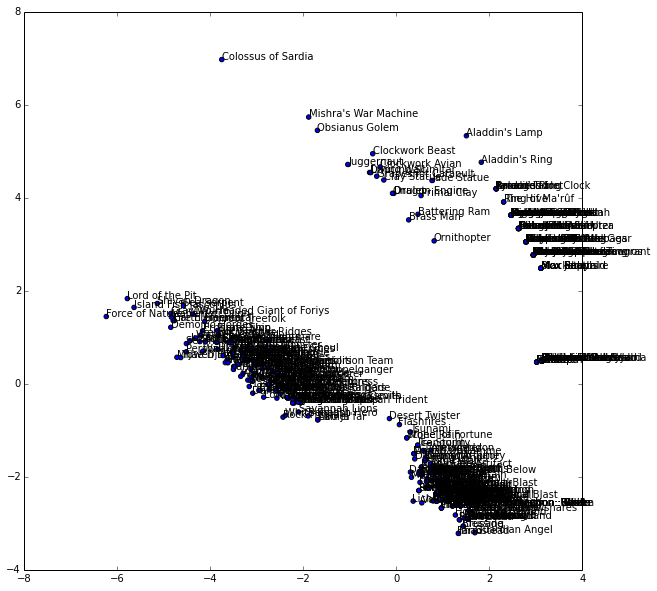

In [459]:

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# from matplotlib.colors import ColorConverter

# blue = ColorConverter.to_rgb['blue']
# green = ColorConverter.to_rgb['green']
# black = ColorConverter.to_rgb['black']
# red = ColorConverter.to_rgb['red']
# white = ColorConverter.to_rgb['white']
# gray = ColorConverter.to_rgb['gray']

numericData = data.copy()
numericData = scale(numericData.fillna(0).select_dtypes(include=['float64', 'int64']))
labels = data.index

# graphColors = [colors[i].replace('Blue', blue).replace('Green',green).replace('Black',black)\
#                    .replace('Red', red).replace('White', white).replace('Colorless', gray) for i in range(len(colors))]

# types = [cardType for cardType in data['Primary Type']]

reduced_data = PCA(n_components=2).fit_transform(numericData)

x = [_[0] for _ in reduced_data]
y = [_[1] for _ in reduced_data]

x2 = [_[0] for _ in reduced_data if _[1] < 1 and _[1] > -2]
y2 = [_[1] for _ in reduced_data if _[1] < 1 and _[1] > -2]

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(x, y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i],y[i]), fontsize = 'medium')
    

/Library/Python/2.7/site-packages/pandas/core/ops.py:562: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


UnicodeEncodeError: 'ascii' codec can't encode character u'\xe2' in position 4: ordinal not in range(128)

In [ ]:
# pca output

In [ ]:
# count most commonly used words in cardText

wordcounts = {}

for row in data['cardText']:
    for word in row:
        if word in wordcounts: wordcounts[word] += 1
        else: wordcounts[word] = 1

sorted(wordcounts)